In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import cv2
import os
import h5py

In [3]:
# Change working directories
#Data location
directory = Path('/Users/apate/OneDrive - Northeastern University/Dennis Lab site/Image processing/IR VIVO data/AMD/240329_Water_immersed')
#Path to save data
workingPath = Path('/Users/apate/OneDrive - Northeastern University/Dennis Lab site/BU Research Drive Data/Amish/Imaging and Processing/Coding/240530_AP_HDR')
here = Path(workingPath).resolve().parent
os.chdir(here)
os.chmod(here, 0o755)

#Experiment title
experiment_title = 'Water_immersed'

In [4]:
#Define wavelength and filter names
laser_wavelengths = {'1': '670', '2': '760', '3': '808'}
emission_filters = {'12': 'BP1150', '13': 'BP1200', '14': 'BP1250', '15': 'BP1300', '16': 'BP1350', '17': 'BP1575'}

# Get the list of darkcount files
darkcount_files = [f for f in os.listdir(directory) if f.startswith('darkcounts')]
darkcount_files.sort(key=lambda x: float(x[10:-3]))

# Initialize a dictionary to store the image file lists
image_files = {}

# Get the list of image files for each parameter combination
for laser_key, laser_value in laser_wavelengths.items():
    for filter_key, filter_value in emission_filters.items():
        key = f"{experiment_title}_{laser_value}_{filter_value}"
        image_files[key] = [f for f in os.listdir(directory) if f.startswith(f"{experiment_title}_{laser_key}_{filter_key}")]
        image_files[key].sort(key=lambda x: float(x.split('_')[-1][:-3]))

# Read the darkcount files and store the data
darkcount_data = []
exposure_times = []
for file in darkcount_files:
    file_path = os.path.join(directory, file)
    with h5py.File(file_path, 'r') as h5f:
        darkcount = h5f['Cube']['Images'][()]
        exposure_time = h5f['Cube']['TimeExposure'][()].item()
        darkcount_data.append(darkcount)
        exposure_times.append(exposure_time)

# Concatenate the darkcount data into an array with dimensions (num_exposure_times, height, width)
darkcount_array = np.squeeze(np.array(darkcount_data))

# Convert exposure_times to a NumPy array
exposure_times = np.squeeze(np.array(exposure_times))

# Read the image files and store the data for each parameter combination
image_arrays = {}
for key, files in image_files.items():
    image_data = []
    for file in files:
        file_path = os.path.join(directory, file)
        with h5py.File(file_path, 'r') as h5f:
            image = h5f['Cube']['Images'][()]
            image_data.append(image)
    image_arrays[key] = np.squeeze(np.array(image_data))

# Calculate the mean and standard deviation of pixel intensities for each exposure time in the darkcount cube
darkcount_mean = np.mean(darkcount_array[:, :, :], axis=(1, 2))
darkcount_std = np.std(darkcount_array[:, :, :], axis=(1, 2))
print(darkcount_mean)
print(darkcount_std)

# Convert the image arrays to NumPy arrays for further processing
for key in image_arrays.keys():
    image_arrays[key] = np.array(image_arrays[key])

# Print the shapes of the arrays
print("Darkcount array shape:", darkcount_array.shape)
print("Exposure times array shape:", exposure_times.shape)
print(exposure_times)
for key in image_arrays.keys():
    print(f"Image array shape for {key}:", image_arrays[key].shape)

[ 799.21032715  964.28184509 1061.37977295 1094.0200592  1105.97271118
 1123.6138031  1137.19124756 1152.92250977 1169.57583618 1184.83742676
 1205.35088806 1236.3617218  1280.04559631 1353.41764221 1498.27137451]
[12.86297416 13.12020853 13.37192913 13.52632673 13.71151908 13.73150302
 13.7205852  13.56561546 13.3067028  13.20703569 13.33763676 13.98644368
 15.13072328 16.61922603 18.79814508]
Darkcount array shape: (15, 640, 512)
Exposure times array shape: (15,)
[1.0000e-04 2.0000e-04 4.0000e-04 8.0000e-04 1.6000e-03 3.2000e-03
 6.4000e-03 1.2800e-02 2.5600e-02 5.1200e-02 1.0240e-01 2.0480e-01
 4.0960e-01 8.1920e-01 1.6384e+00]
Image array shape for Water_immersed_670_BP1150: (15, 640, 512)
Image array shape for Water_immersed_670_BP1200: (15, 640, 512)
Image array shape for Water_immersed_670_BP1250: (15, 640, 512)
Image array shape for Water_immersed_670_BP1300: (15, 640, 512)
Image array shape for Water_immersed_670_BP1350: (15, 640, 512)
Image array shape for Water_immersed_670_

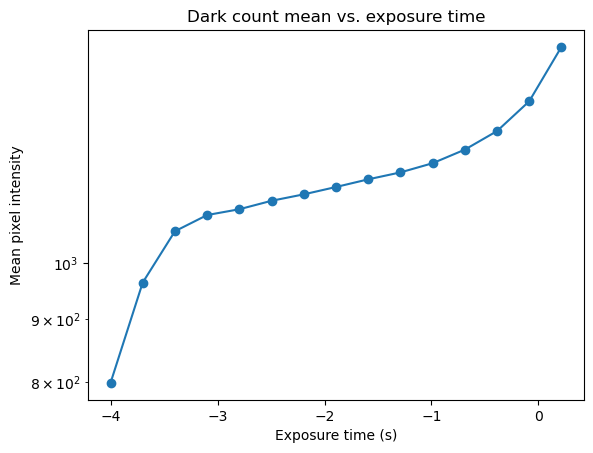

In [5]:
#Plot dark counts to determine thermal noise

plt.semilogy(np.log10(exposure_times), darkcount_mean, 'o-')
plt.xlabel('Exposure time (s)')
plt.ylabel('Mean pixel intensity')
plt.title('Dark count mean vs. exposure time')
plt.show()



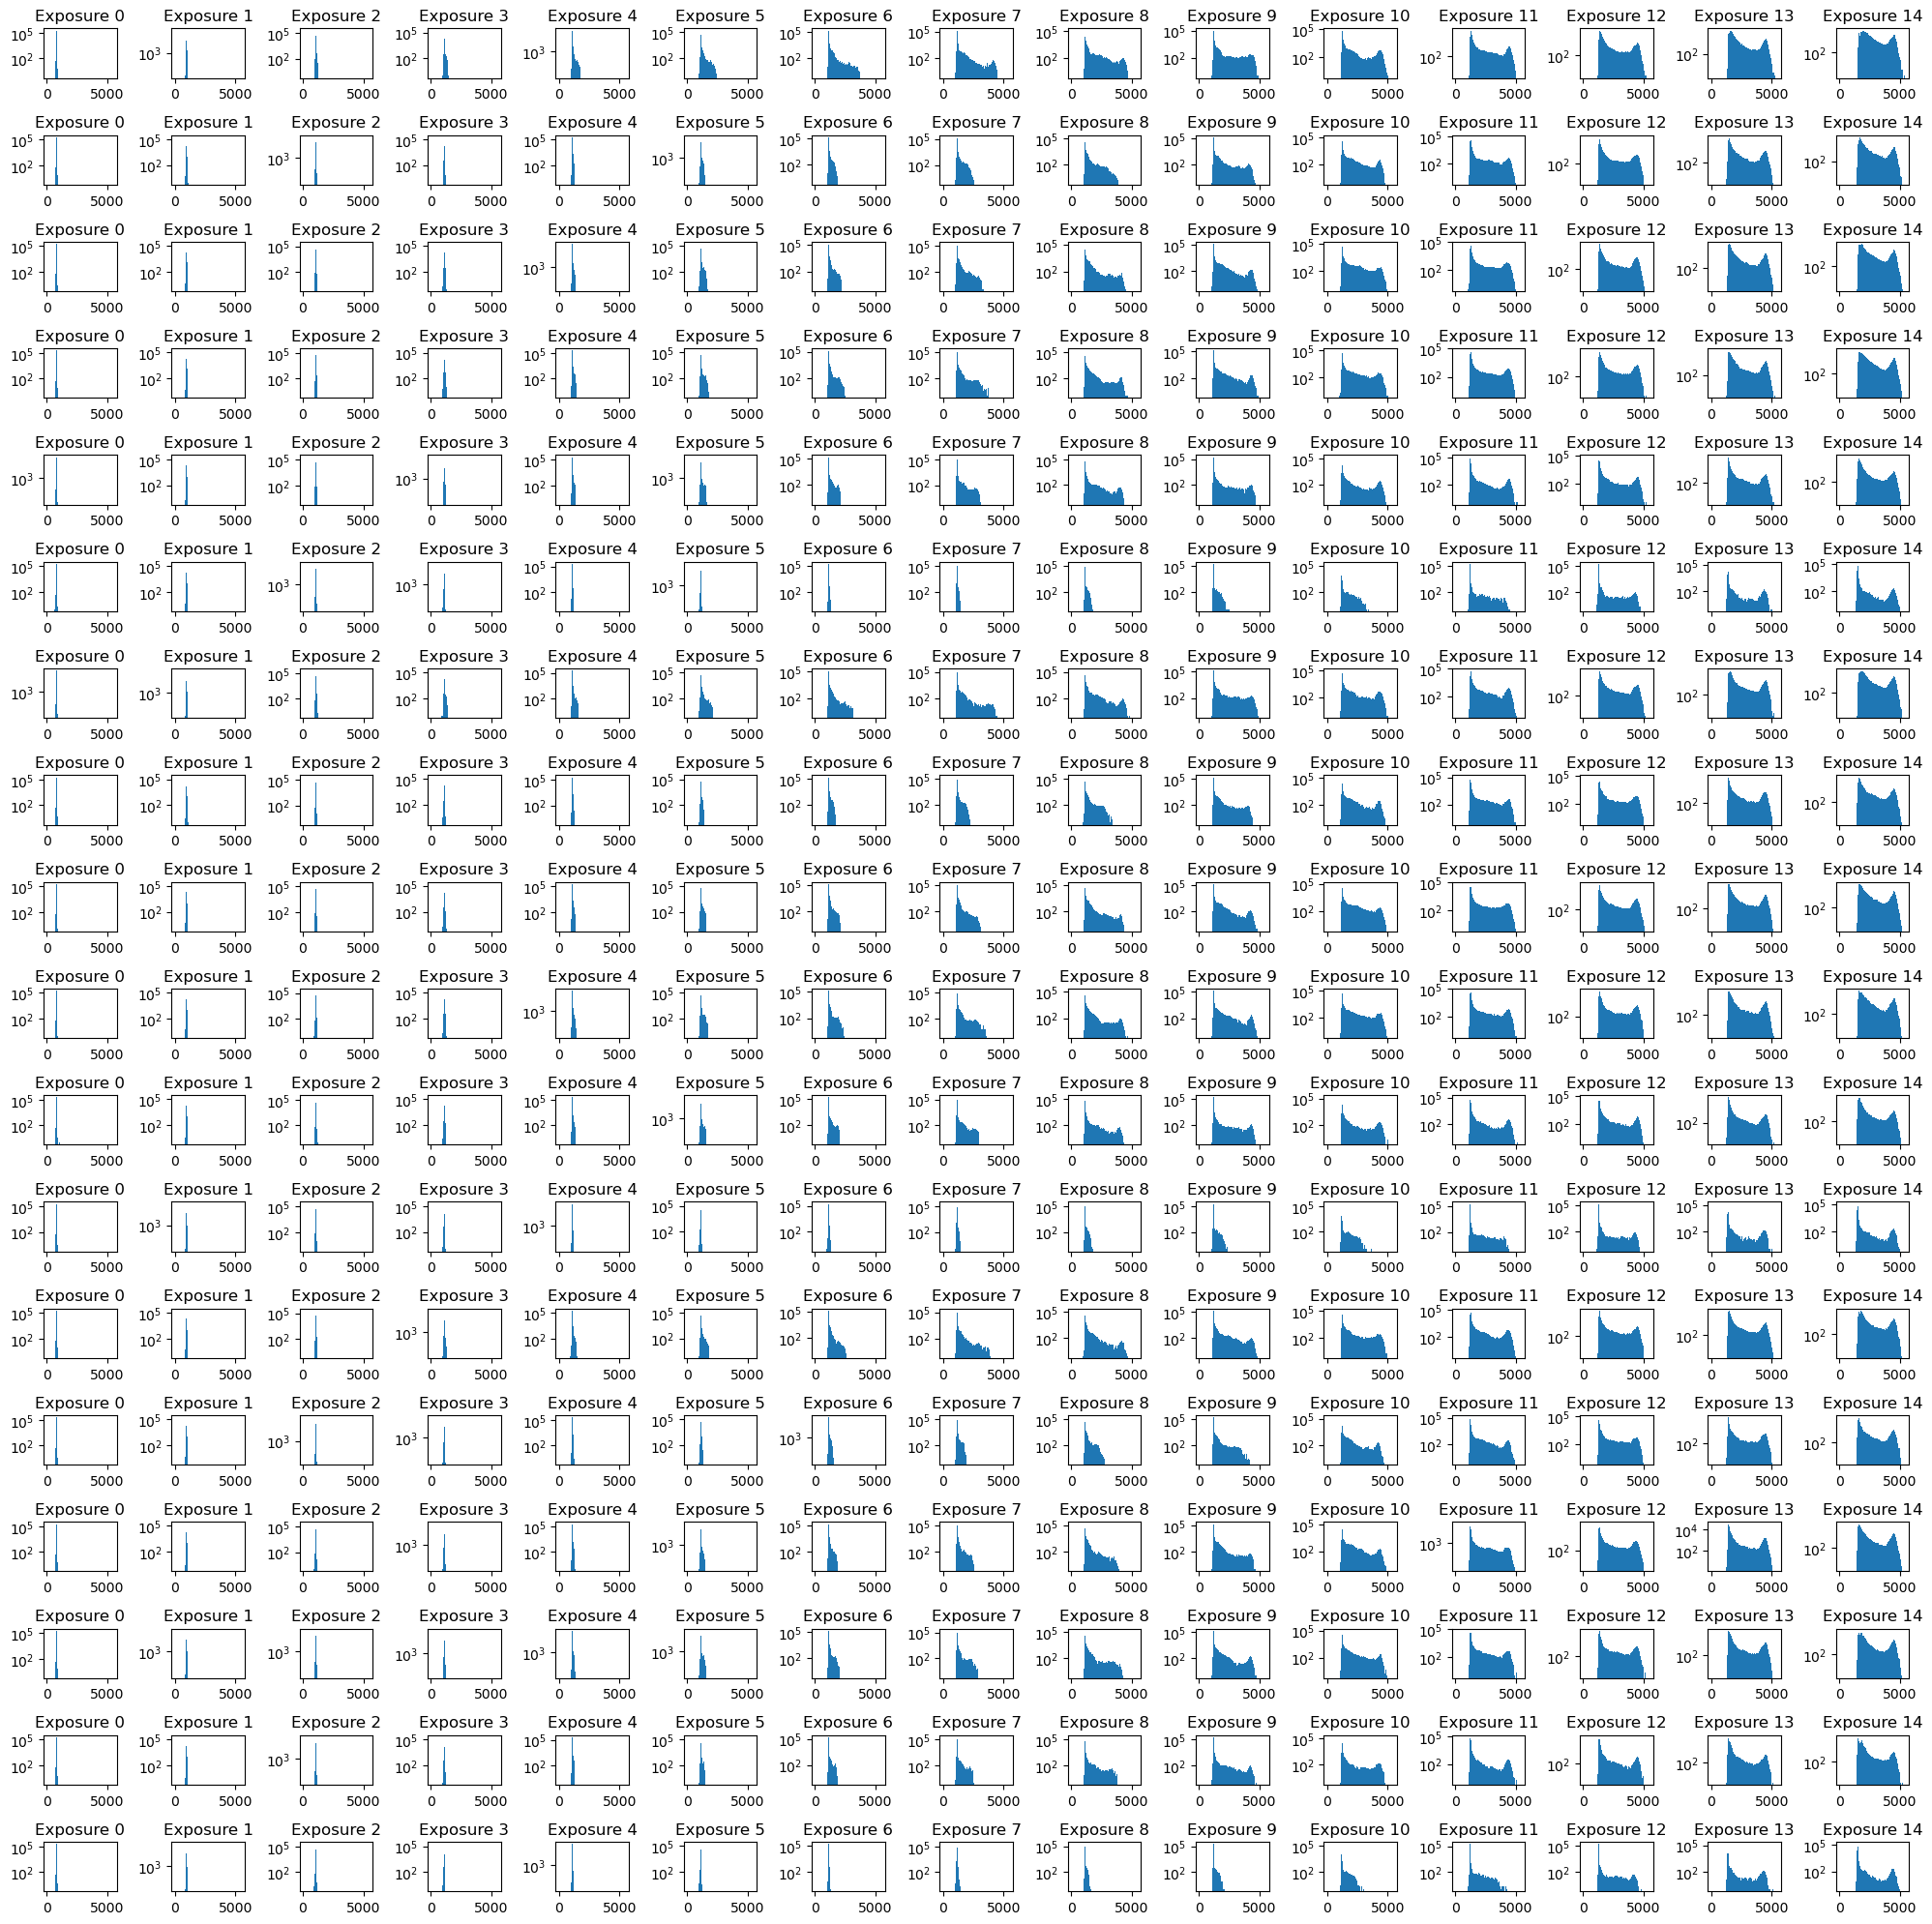

In [44]:
#Display histograms of images

sfig, axs = plt.subplots(len(image_arrays.keys()),len(exposure_times), figsize=(20, 20))
c=int(0)
for key in image_arrays.keys():
    image_data = image_arrays[key]
    for i in range(0,len(exposure_times)):
        axs[c,i].hist(image_data[i,:,:].flatten(), bins=256, range = (0,5500))
        axs[c,i].set_title(f"Exposure {i}")
        axs[c,i].set_yscale('log')
    c=c+1
    #if c==1:#len(image_arrays.keys()): #breakpoint for testing
    #    break
plt.tight_layout()
plt.show()

In [43]:
for key in image_arrays.keys():
    print(np.amax(image_arrays[key][14,:,:]))

5378
5168
5226
5243
5211
5243
5364
5144
5206
5275
5262
5173
5248
5116
5178
5213
5230
5202


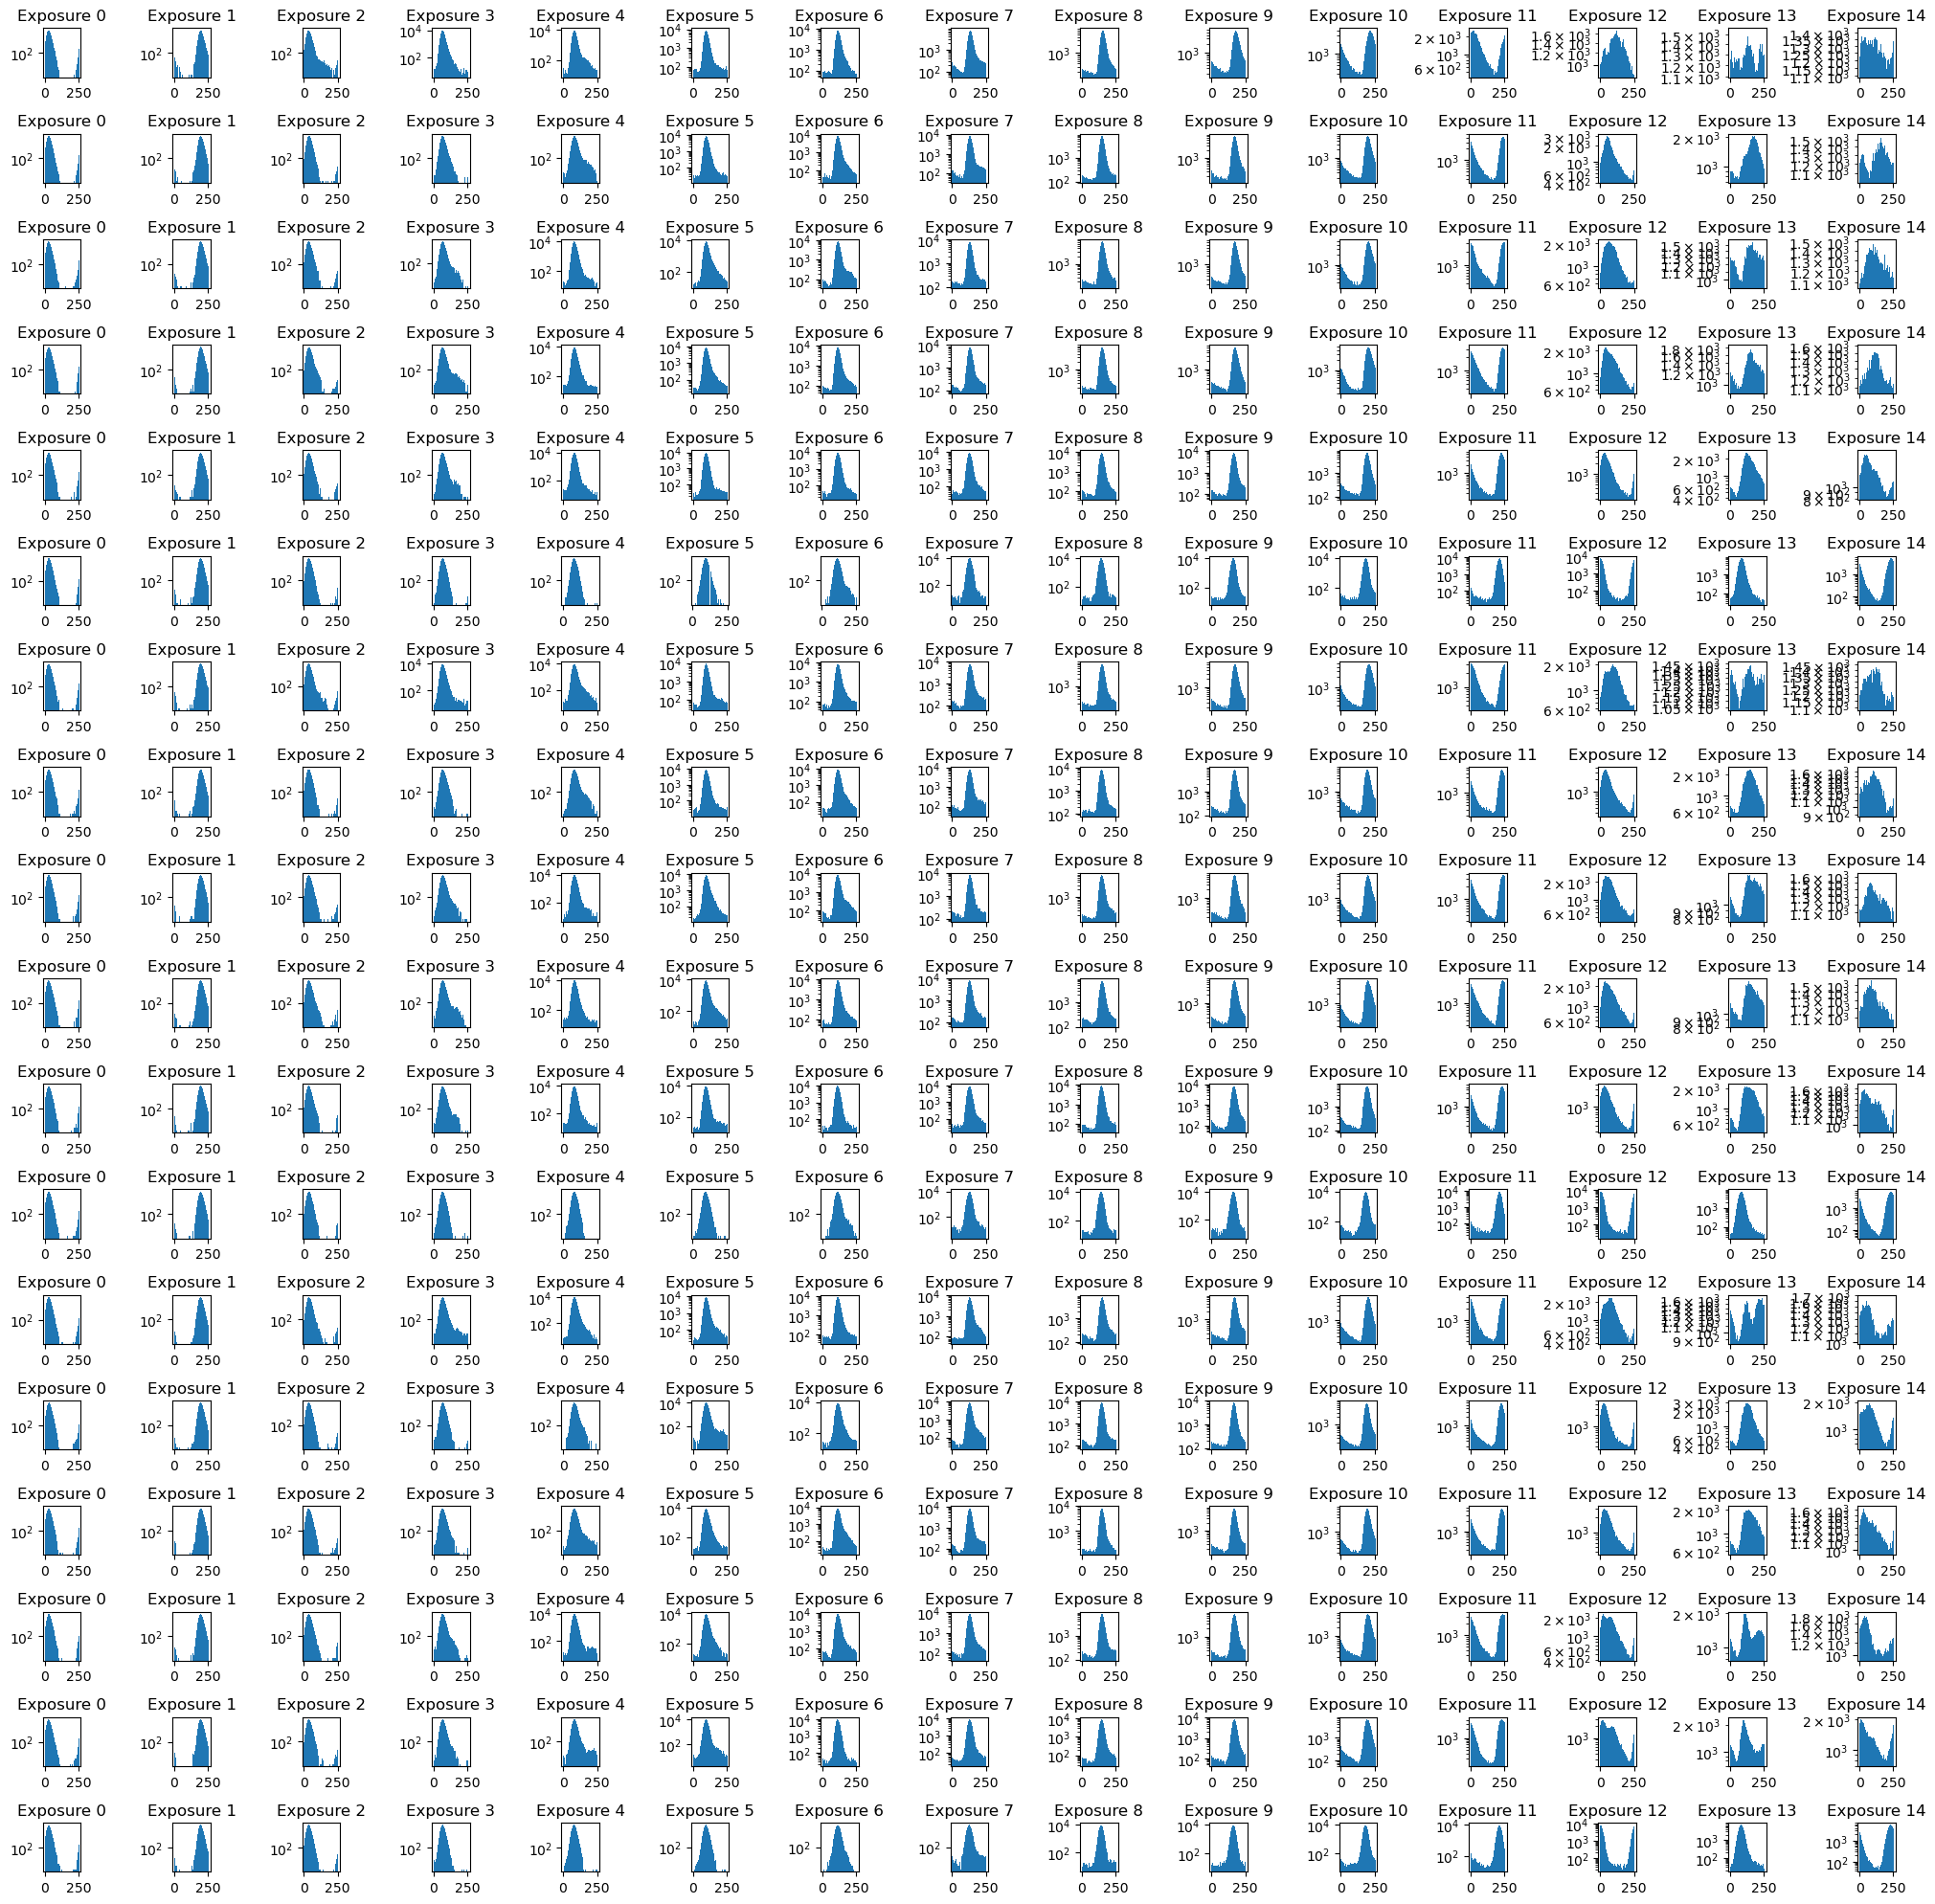

In [39]:
#Display histograms of images after uint8 conversion

sfig, axs = plt.subplots(len(image_arrays.keys()),len(exposure_times), figsize=(20, 20))
c=int(0)
for key in image_arrays.keys():
    image_data = image_arrays[key].astype(np.uint8)
    for i in range(0,len(exposure_times)):
        axs[c,i].hist(image_data[i,:,:].flatten(), bins=256)
        axs[c,i].set_title(f"Exposure {i}")
        axs[c,i].set_yscale('log')
    c=c+1
    #if c==1:#len(image_arrays.keys()): #breakpoint for testing
    #    break
plt.tight_layout()
plt.show()



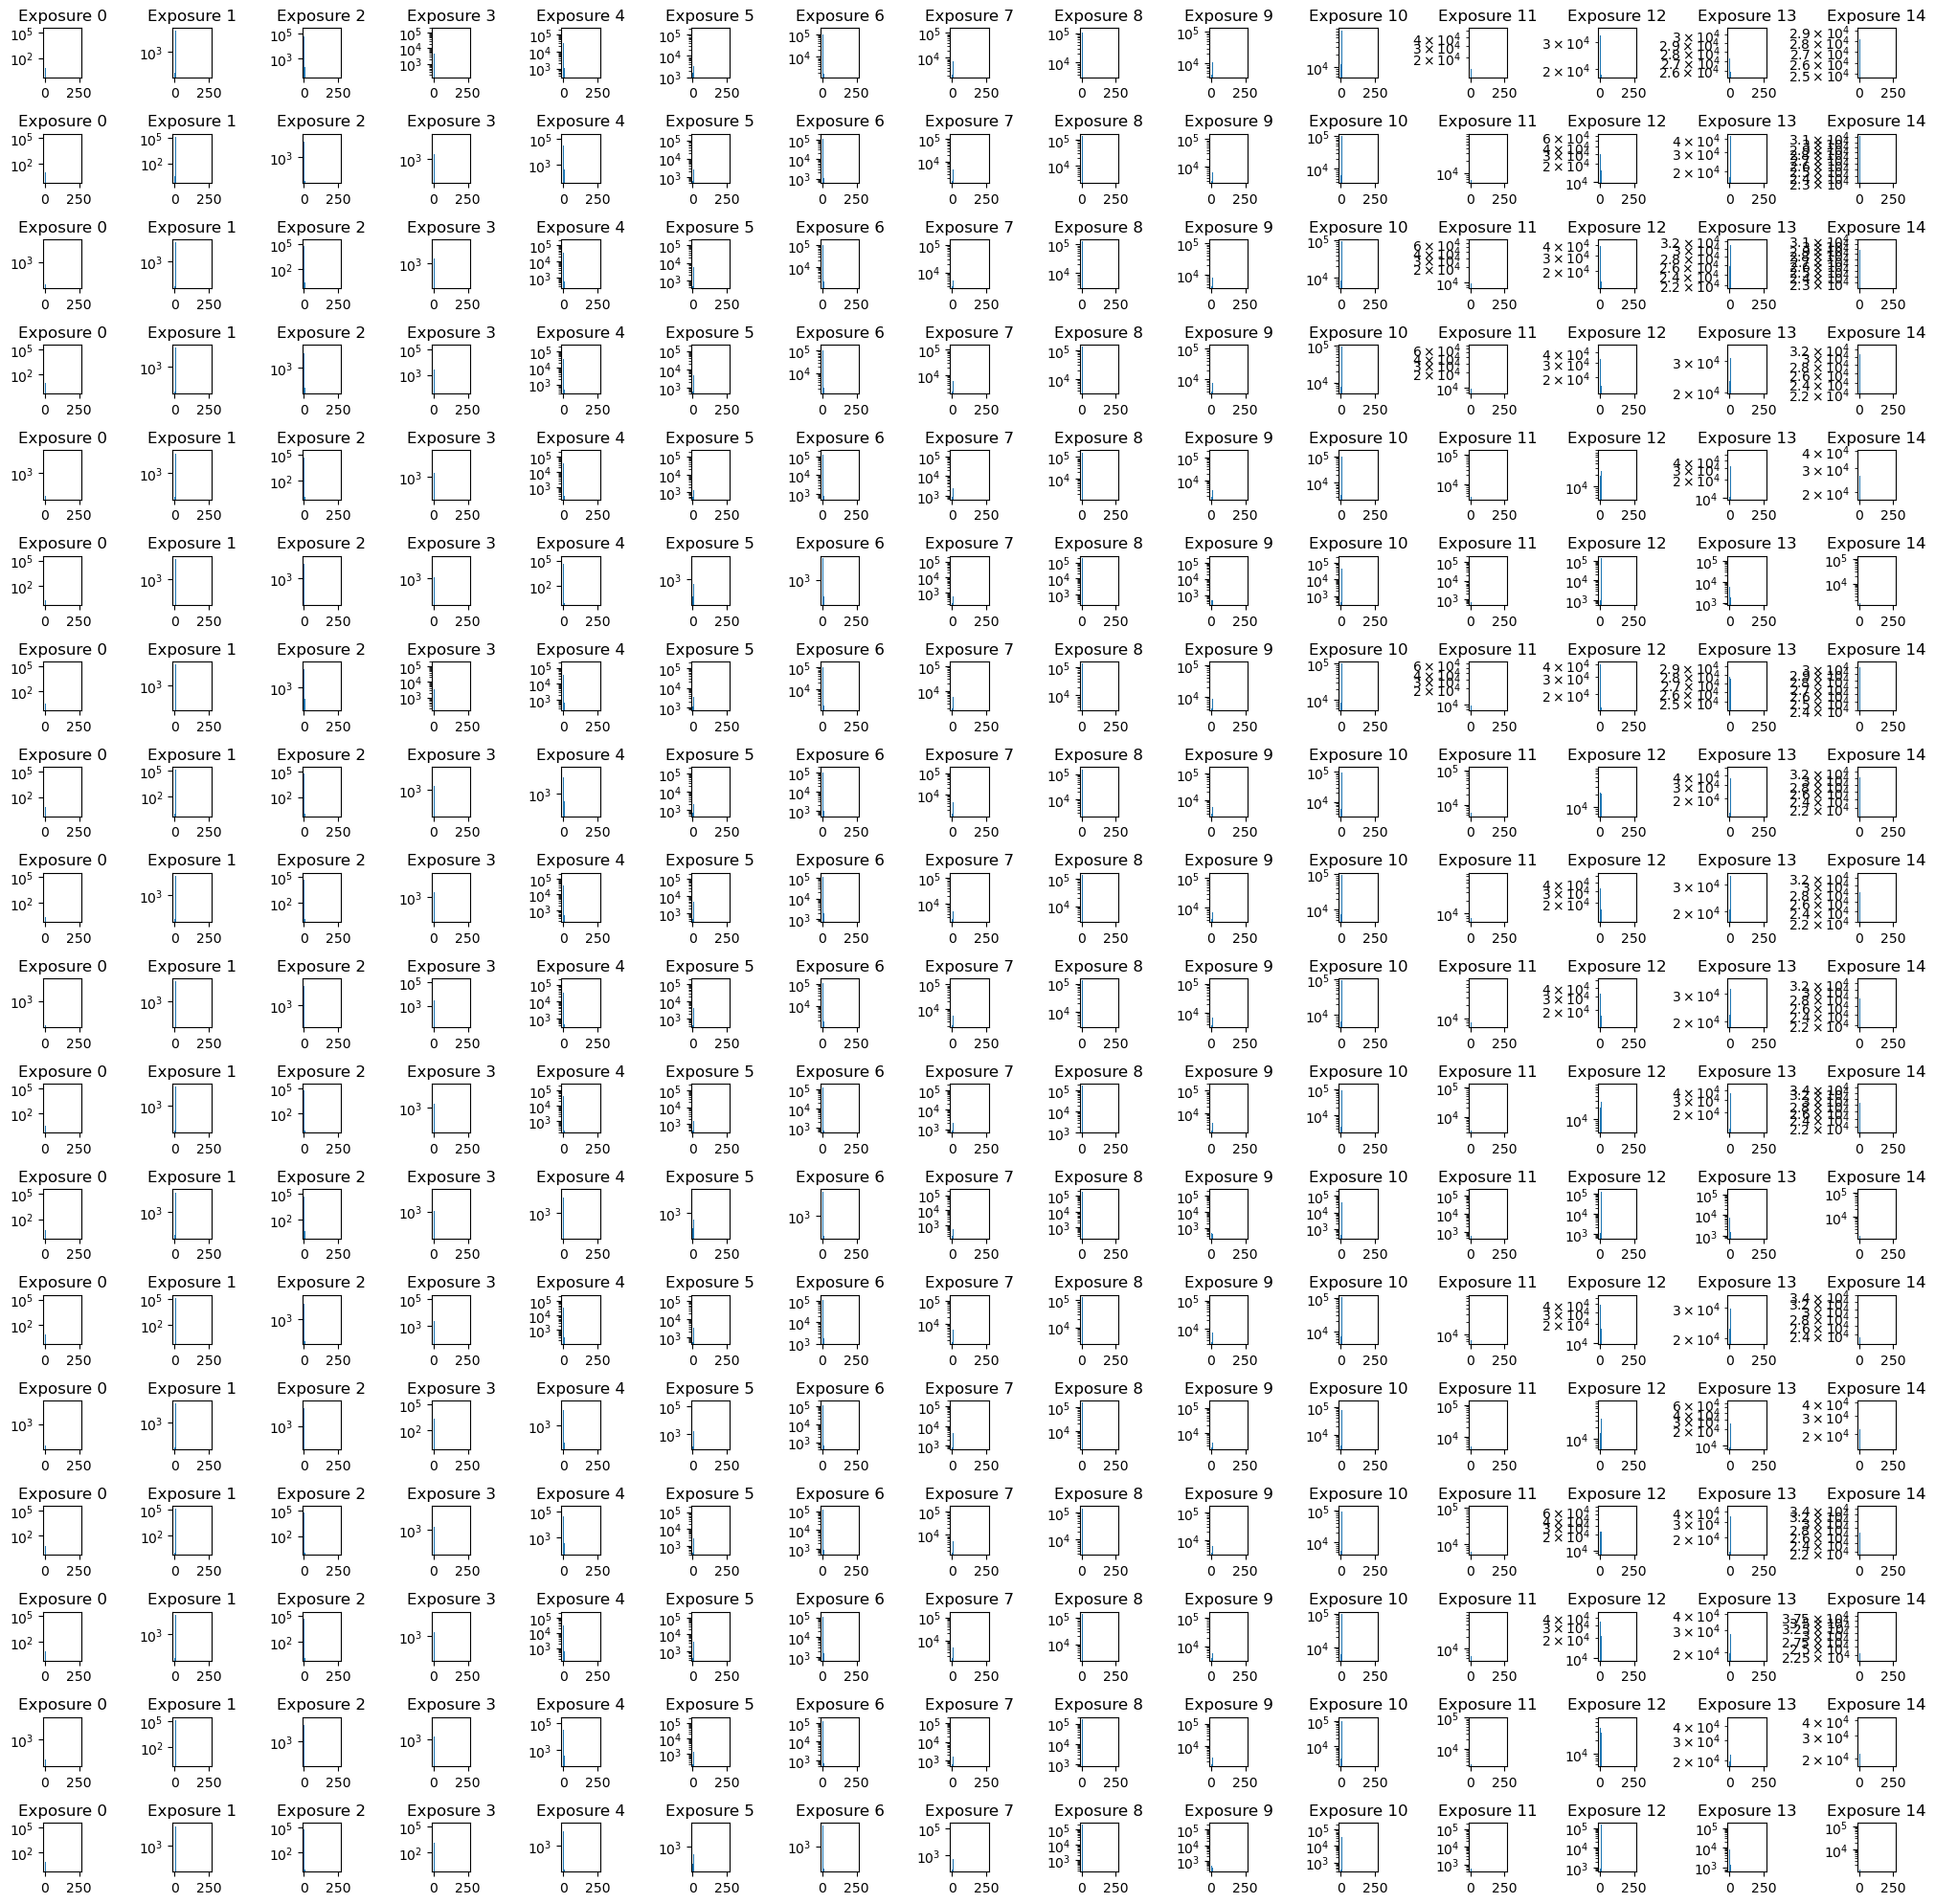

In [50]:
#Generate raw images with uint8 conversion without changing dynamic range of images. plot the histograms
def normalize_to_uint8(images, image_max):
    image_data = np.uint8(255 * (images) / (image_max))
    return   image_data

#Display histograms of images after uint8 conversion

sfig, axs = plt.subplots(len(image_arrays.keys()),len(exposure_times), figsize=(20, 20))
c=int(0)
for key in image_arrays.keys():
    image_data = normalize_to_uint8(image_arrays[key], 5500)
    for i in range(0,len(exposure_times)):
        axs[c,i].hist(image_data[i,:,:].flatten(), bins=256, range = (0,255))
        axs[c,i].set_title(f"Exposure {i}")
        axs[c,i].set_yscale('log')
    c=c+1
    #if c==1:#len(image_arrays.keys()): #breakpoint for testing
    #    break
plt.tight_layout()
plt.show()

In [21]:
#For each imaging condition, generate an HDR image


alignMTB = cv2.createAlignMTB()
aligned_images = np.empty([len(image_arrays.keys()), len(exposure_times), 640, 512], dtype=np.uint8)
c = 0
for key in image_arrays.keys():
    image_data = image_arrays[key].astype(np.uint8)
    print(image_data.shape)
    #Align images between exposures by converting to median threshold bitmaps
    aligned_images[c,:,:,:] = alignMTB.process(image_data,np.empty(image_data.shape, dtype=np.uint8))
    c = c+1

    

(15, 640, 512)


error: OpenCV(4.9.0) D:\bld\libopencv_1716156177264\work\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xc24125dd::Set<1,-1,-1>,struct cv::impl::A0xc24125dd::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


(256,)
(512,)
(768,)
(1024,)
(1280,)
(1536,)
(1792,)
(2048,)
(2304,)
(2560,)
(2816,)
(3072,)
(3328,)
(3584,)
(3840,)
(4096,)
(4352,)
(4608,)
dict_keys(['Water_immersed_670_BP1150', 'Water_immersed_670_BP1200', 'Water_immersed_670_BP1250', 'Water_immersed_670_BP1300', 'Water_immersed_670_BP1350', 'Water_immersed_670_BP1575', 'Water_immersed_760_BP1150', 'Water_immersed_760_BP1200', 'Water_immersed_760_BP1250', 'Water_immersed_760_BP1300', 'Water_immersed_760_BP1350', 'Water_immersed_760_BP1575', 'Water_immersed_808_BP1150', 'Water_immersed_808_BP1200', 'Water_immersed_808_BP1250', 'Water_immersed_808_BP1300', 'Water_immersed_808_BP1350', 'Water_immersed_808_BP1575'])


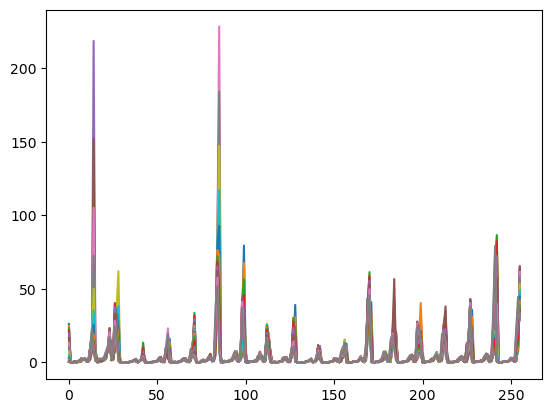

In [22]:


#Define camera response function
responseDebevec = np.array([])
for key in image_arrays.keys():
    images = image_arrays[key].astype(np.uint8)

    calibrateDebevec = cv2.createCalibrateDebevec()
    responseDebevec = np.append(responseDebevec, calibrateDebevec.process(images,exposure_times.astype(np.float32)))
    print (responseDebevec.shape)
print (image_arrays.keys())
responseDebevec = np.reshape(responseDebevec, [256,len(image_arrays.keys())])
#Plot camera response function

c = 0
for key in image_arrays.keys():
    plt.plot(np.arange(256), responseDebevec[:,c])
    c = c+1
    



(18, 640, 512)


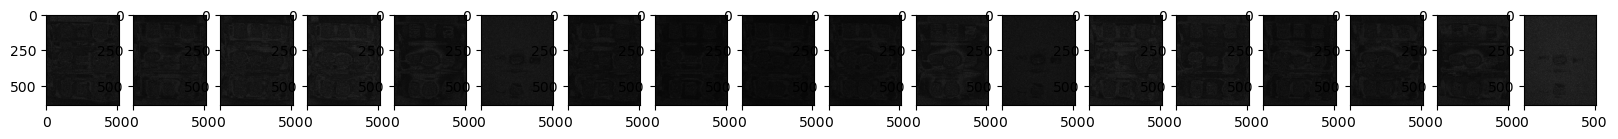

In [ ]:
#Merge images with image fusion

HDRimages = np.empty([len(image_arrays.keys()), 640, 512])
print(HDRimages.shape)
c=0
for key in image_arrays.keys():
    images = image_arrays[key].astype(np.uint8)
    
    merge_debevec = cv2.createMergeDebevec() #creates a MergeDebevec object
    hdr_debevec = merge_debevec.process(images, exposure_times.astype(np.float32), responseDebevec[:,c].astype(np.float32)) #Process this object with darkcount_array, exposure_times, and image_arrays


    #Save images
    HDRimages[c,:,:] = np.reshape(hdr_debevec, [640,512])#hdr_debevec
    c = c+1

#display HDR images
sfig, axs = plt.subplots(1, len(image_arrays.keys()), figsize=(20, 5))
for j in range(0,len(image_arrays.keys())):    

    axs[j].imshow(HDRimages[j,:,:], cmap='gray')



In [ ]:
#Tonemapping
tonemap = cv2.createTonemapDurand(1.5,4,1.0,1,1)
ldr_debevec = tonemap.process(hdr_debevec)

#Display tonemapped images
plt.imshow(ldr_debevec)
plt.show()

#Save
cv2.imwrite(f"{experiment_title}.png", ldr_debevec*255)